In [1]:
# 手写数字识别
# MNIST
#  - 训练集 50000
#  - 验证集 10000
#  - 图像大小 28x28
#  - 10类

In [2]:
# LeNet结构
#  - Input: 32x32 image (通过 5x5的卷积)
#  - C1 feature map: 6@28x28 (通过 2x2的 pooling)
#  - S2 feature map: 6@14x14 (通过 5x5的卷积)
#  - C3 feature map: 16@10x10 (通过 2x2的 pooling)
#  - S4 feature map: 16@5x5 (拉平称一个向量, 为1x400)
#  - full: 全连接层, 输入是400, 输出是120
#  - full: 全连接层, 输入是120, 输出是84
#  - Gauss: 全连接层, 输入是84, 输出是10 (类)

# 总结
# 使用卷积层来学习图片空间信息
# 使用全连接层来转化为类别的空间

In [3]:
# 卷积神经网络 (LeNet)
# LeNet由两个部分组成: 卷积编码器和全连接层密集块
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28) # 将输入变成一个28x28, 通道数为1, 批量大小计算(-1)的矩阵
    
net = torch.nn.Sequential(
    Reshape(), 
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), # 输入通道是1, 输出通道是6, 因为输入图片是32x32, 我们需要补充
    # 为了非线形, 我们要在卷积后加sigmoid激活函数
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), # 输入通道是6, 输出是16
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(), # 池化层后, 拉平为一个1维的向量
    nn.Linear(16*5*5, 120), nn.Sigmoid(), # 将拉平后的向量经过全连接层, 然后经过sigmoid函数
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

# 检查模型
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)
    
# 理解可以是, 将输入的图片一直变小, 将通道数增加, 因为通道数是识别的pattern.
# 随着模型越深, 输入的size会越变越小, 但是通道数会一直增加

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [4]:
# LeNet在FashionMNIST数据集上的表现
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [10]:
# 对evaluate_accuracy函数进行轻微修改
def evaluate_accuracy_gpu(net, data_iter, device=None):  
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device # 这里意思是: 如果没告诉device, 就去看看网络存在哪里
    metric = d2l.Accumulator(2) # 创造一个累加器
    for X, y in data_iter: # 对每一个data, 先挪到那个device
        if isinstance(X, list): # 如果是个list, 就一个个挪
            X = [x.to(device) for x in X]
        else: # 如果是个tensor, 就挪一次
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel()) # 算accuracy后, 和y的元素个数放到累加器
    return metric[0] / metric[1]

In [11]:
# 为了GPU改一点
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d: # 如果是这两个层
            nn.init.xavier_uniform_(m.weight)  # 就用这个初始化weight
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i+1) % (num_batches //5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches, 
                            (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on{str(device)}')
          

loss 0.461, train acc 0.828, test acc0.792
11272.7 examples/sec oncpu


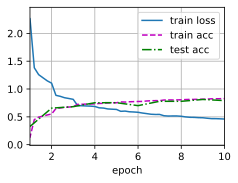

In [12]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())